In [101]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Extract Data and read csv file into a DataFrame

In [58]:

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [60]:
df = pd.read_csv(csv_path)

In [61]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


# Plot Data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4035e6d790>],
      dtype=object)

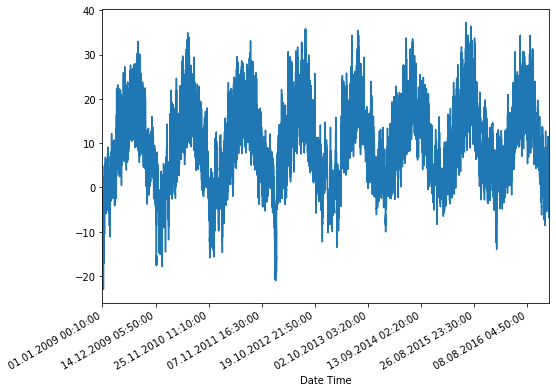

In [67]:

plot_df = df['T (degC)']
plot_df.index = df['Date Time']
plot_df.plot(subplots=True)


## To Do: What's KDE Plot

In [ ]:
# What's kde plot???
plot_df.plot(kind='kde')

# Extracting Temperature to a Dataframe

In [68]:
df_s = pd.DataFrame({'Date Time':plot_df.index, 'Temperature':plot_df.values})
df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
df_s = df_s.set_index('Date Time')
df_s.head(100)

,Temperature
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27
...,...
2009-01-01 16:00:00,-5.40
2009-01-01 16:10:00,-5.31
2009-01-01 16:20:00,-5.28


# Decomposition of timeseries into Trend, Seasonality and Residuals

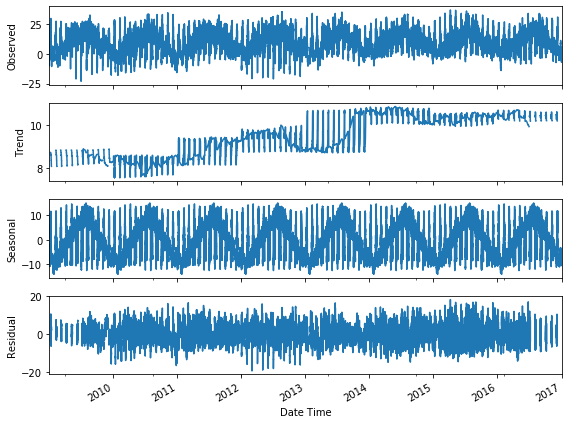

In [69]:
# Need to write frequency calculation
result = seasonal_decompose(df_s, freq=52560)
result.plot()
plt.show()

# Histogram Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f402c04a610>]],
      dtype=object)

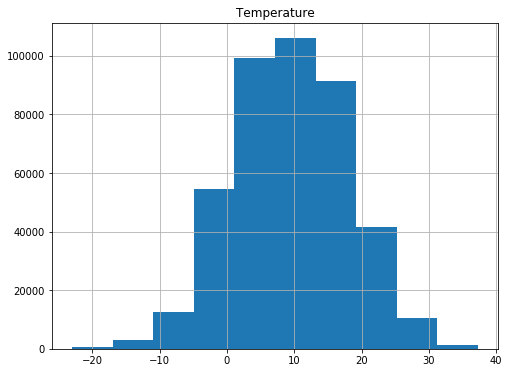

In [70]:
df_s.hist()

# Check if Time Series is Stationary

In [71]:
def test_stationarity(df_s):
    X = df_s.values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return [{'Mean-1': mean1,'Mean-2': mean2}, {'Variance-1':var1,'Variance-2':var2}]
    

In [72]:
results = test_stationarity(df_s)
print("Simple Results:")
print("Mean for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[0].get('Mean-1'), results[0].get('Mean-2')))
print("Variance for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[1].get('Variance-1'), results[1].get('Variance-2')))

Simple Results:
Mean for first 1/2 of data: 8.825443015099275, Mean for Second 1/2 of data: 10.07484872263121
Variance for first 1/2 of data: 76.91277356607266, Mean for Second 1/2 of data: 64.2125748277876


# Dickey Fuller test for stationarity check

#### Todo: Actually the P value is less than 0.05 implies we can reject null hypothesis and consider that timeseries is stationary. Here timeseries is not stationary but p value is less than 0.05. Don't know why!!

# Dickey Fuller test using statstools function

In [73]:
#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag =1)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [74]:
data = df_s['Temperature']
data = data.values.flatten()
adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                -1.729445e+01
p-value                        5.678323e-30
#Lags Used                     1.000000e+00
Number of Observations Used    4.205490e+05
Critical Value (1%)           -3.430366e+00
Critical Value (5%)           -2.861547e+00
Critical Value (10%)          -2.566774e+00
dtype: float64


# Dickey Fuller test by writing the function from scratch

In [75]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts):
    """
    Augmented Dickey-Fuller unit root test
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Get the dimension of the array
    nobs = ts.shape[0]
    
    # We use 1 as maximum lag in our calculations
    maxlag = 1
    
    # Calculate the discrete difference
    tsdiff = np.diff(ts)
    
    # Create a 2d array of lags, trim invalid observations on both sides
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    # Get dimension of the array
    nobs = tsdall.shape[0] 
    
    # replace 0 xdiff with level of x
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    tsdshort = tsdiff[-nobs:]
    
    # Calculate the linear regression using an ordinary least squares model    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    # Get approx p-value from a precomputed table (from stattools)
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return pvalue

In [78]:
adf(df_s['Temperature'])

5.6783226105027144e-30

# Removing Non Stationarity

In [ ]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [7]:
def difference_using_shift(dataset,interval):
    return dataset - dataset.shift(interval)
    

In [10]:
def perform_seasonal_decomposition(series_data):
    series_data = series_data.dropna()
    df_s = pd.DataFrame({'Date Time':series_data.index, 'Temperature':series_data.values})
    df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
    df_s = df_s.set_index('Date Time')
    result = seasonal_decompose(df_s, freq=52560)
    result.plot()
    plt.show()

In [ ]:
# It's taking a long time for somereason
plot_df = difference(df['T (degC)'])
plot_df.index = df['Date Time'].values[1:]
perform_seasonal_decomposition(plot_df)

# Using Differencing

In [ ]:
plot_df = difference_using_shift(df['T (degC)'],1)
plot_df.index = df['Date Time']
perform_seasonal_decomposition(plot_df)
print(plot_df.shape)

# 30 days Data

In [79]:
# Why 4320?
# 6 observations per hour. 24 hours per day => 24*6 = 144 observations per day => 144*30 per 30 days => 4320
day_30_data = plot_df.iloc[1:4320]

In [42]:
TRAIN_SPLIT = 4316

In [94]:
train, test = day_30_data[1:TRAIN_SPLIT+1], day_30_data[TRAIN_SPLIT:]

# AR Model

In [95]:
from statsmodels.tsa.ar_model import AR
model = AR(train.values)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start = len(train), end = len(train)+len(test)-1)
print('Predictions:')
print('-----------------')
print(predictions)
print(test)

Lag: 31
Coefficients: [-0.0056596   1.59714978 -0.83742627  0.34582673 -0.11109001  0.09065839
 -0.07586046  0.08007584 -0.09064798  0.0036571   0.01344033  0.01534856
  0.01851992 -0.06418204  0.08371265 -0.13145263  0.1287144  -0.07982642
  0.05379819 -0.07654311  0.0501575  -0.02899571 -0.01670088  0.00696483
  0.02911228 -0.06679429  0.06172901 -0.01331696  0.01845525  0.0121517
 -0.03547004  0.01712588]
Predictions:
-----------------
[-2.40059684 -2.38469133 -2.37056405]
Date Time
30.01.2009 23:40:00   -2.44
30.01.2009 23:50:00   -2.43
31.01.2009 00:00:00   -2.48
Name: T (degC), dtype: float64


In [97]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

Test MSE: 0.005


# MA Model

In [98]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train.values, order=(0, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start = len(train), end = len(train)+len(test)-1)
print('Predictions:')
print('-----------------')
print(predictions)

Predictions:
-----------------
[-3.10095171 -3.6793565  -3.6793565 ]


In [99]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4316
Model:                     ARMA(0, 1)   Log Likelihood              -10665.428
Method:                       css-mle   S.D. of innovations              2.863
Date:                Thu, 23 Jan 2020   AIC                          21336.856
Time:                        11:47:22   BIC                          21355.967
Sample:                             0   HQIC                         21343.604
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6794      0.087    -42.515      0.000      -3.849      -3.510
ma.L1.y        0.9863      0.002    565.900      0.000       0.983       0.990
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0139           +0.0000j            1.0139            0.5000
-----------------------------------------------------------------------------
"""

# Data visualisation using AR and MA models

In [104]:
# One year of data => 365*144 => 52560 nearly
temp_df = plot_df[1: 52557]

In [102]:
def plot_data(results):
    df_t = pd.DataFrame({'index':pd.to_datetime(temp_df.index).strftime('%d-%m-%Y'),'Actual temp':temp_df})
    df_p = pd.DataFrame({'index':pd.to_datetime(results.fittedvalues.index).strftime('%d-%m-%Y'),'Predicted temp':results.fittedvalues})
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    df_t.plot(y=["Actual temp"], ax=ax,color='blue')
    df_p.plot(y=["Predicted temp"], ax=ax2, ls="--",color='red')


    ax.legend(loc=1)
    ax2.legend(loc=2)
    fig.autofmt_xdate()
    plt.show()

In [105]:
model = ARIMA(temp_df,order=(0,1,2))
results_ma = model.fit(disp=-1)
temp_df = temp_df[1:len(temp_df)]
# Residual sum of squares
print('Residual Sum of squares: {}'.format(sum((results_ma.fittedvalues-temp_df)**2)))

Residual Sum of squares: 7871772.946324181


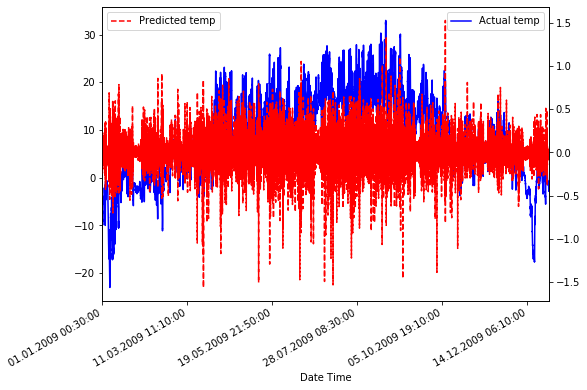

In [106]:
plot_data(results_ma)

Residual Sum of squares: 7870993.398570484


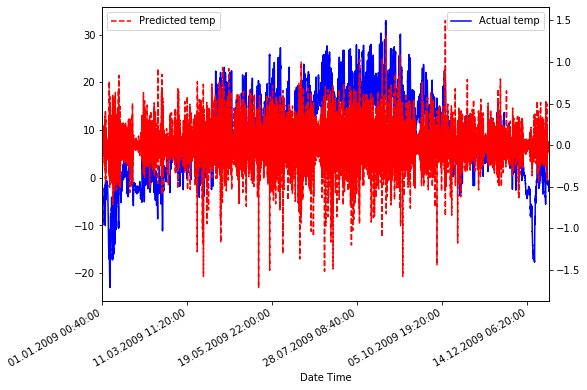

In [107]:
model = ARIMA(temp_df,order=(2,1,0))
results_ar = model.fit(disp=-1)
temp_rss = (results_ar.fittedvalues-temp_df).dropna()

print('Residual Sum of squares: {}'.format(sum(temp_rss**2)))
plot_data(results_ar)